# Training PyTorch ResNet in your TensorFlow Projects

### Framework Incompatibility
Practitioners with large codebases written in other frameworks, such as PyTorch, are unable to take advantage of TensorFlow's rich ecosystem of state-of-the-art (SOTA) deployment toolings, as this requires converting their code manually and inaccurately.

[Ivy’s transpiler](https://unify.ai/blog/unifying-with-ivy) allows ML practitioners to dynamically connect libraries, layers and models from different frameworks together. For PyTorch users, the transpiler provides a seamless and accurate way to introduce code written in PyTorch to TensorFlow pipelines.

In this blog post, we’ll go through an example of how the transpiler can be used to convert a model from PyTorch to TensorFlow and train the converted model in TensorFlow.

### Transpiling a PyTorch model to TensorFlow

#### About the transpiled model
To illustrate a typical transpilation workflow, we’ll be converting a pre-trained ResNet model from PyTorch to TensorFlow, and using the transpiled model to run inference.

ResNet owes its name to its residual blocks with skip connections that enable the model to be extremely deep. Even though including skip connections is a common idea in the community now, it was a revolutionary architectural choice and allowed ResNet to reach up to 152 layers with no vanishing or exploding gradient problems during training.

Architecturally, a ResNet block is similar to a ConvNext block but differs in terms of the specific convolutional layers used, grouped convolution, normalization, activation function, and downsampling. Going through the details of the models is outside the scope of this demo, interested readers might want to go through the [paper](https://arxiv.org/pdf/1512.03385).

#### Installation

Since we want the packages to be available after installing, after running the first cell, the notebook will automatically restart.

You can then do Runtime -> Run all after the notebook has restarted, to run all of the cells.

Make sure you run this demo with GPU enabled!

In [8]:
!pip install -q ivy

!python3 -m pip install torchvision
!python3 -m pip install astor

exit()

#### Setting-up the source model

We import the necessary libraries. We’ll mostly use the PyTorch's Torchvision API to load the model, Ivy to transpile it from PyTorch to TensorFlow, and TensorFlow functions to  fine-tune the transpiled model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import logging
import tensorflow as tf
try:
   tf.config.experimental.set_memory_growth(
      tf.config.list_physical_devices("GPU")[0], True
   )
except:
   pass

# Filter TensorFlow info and warning messages
tf.get_logger().setLevel(logging.ERROR)
import os
import ivy
ivy.set_default_device("gpu:0")
import torch
import torchvision
from torchvision import datasets, models, transforms

torch.manual_seed(0)
tf.random.set_seed(0)

#### Load the Data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

> **Note:** Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory by running the following cell

In [2]:
import requests
import os
import zipfile

# URL of the zip file you want to download
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'  # Replace with your URL

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Get the file name from the URL
    filename = os.path.basename(url)

    # Specify where you want to save the zip file (current working directory in Colab)
    zip_save_path = os.path.join(os.getcwd(), filename)

    # Write the content to the zip file
    with open(zip_save_path, 'wb') as f:
        f.write(response.content)

    print(f"Zip file downloaded successfully as '{filename}' in the current working directory.")

    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_save_path, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())

    print("Zip file contents extracted successfully.")

    # Optionally, you can remove the zip file after extraction
    os.remove(zip_save_path)
    print(f"Zip file '{filename}' deleted.")

else:
    print(f"Failed to download zip file from '{url}'. Status code: {response.status_code}")


Zip file downloaded successfully as 'hymenoptera_data.zip' in the current working directory.
Zip file contents extracted successfully.
Zip file 'hymenoptera_data.zip' deleted.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    ) for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True,
        num_workers=4
    ) for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize a few images

We also load an input tensor to be passed as the input for transpilation

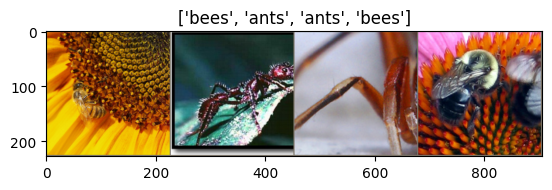

In [4]:
import numpy as np
from matplotlib import pyplot as plt


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Load the pre-trained model

We then initialise our ML model through the torchvision API, specifically we’ll be using ResNet18. Note that while we are using a model from the torchvision models API for this demonstration, it would still work with any arbitrary PyTorch model regardless of how it is being loaded. You can load models hosted on different platforms including local models.

In [5]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Converting the model from TensorFlow to PyTorch

With the model loaded, we can run the transpilation to TensorFlow eagerly. As we explain in our docs, [eager transpilation](https://unify.ai/docs/ivy/demos/learn_the_basics/05_lazy_vs_eager.html) involves manually providing dummy input arguments (`tf.ones(4, 3, 224, 224)` in our example) to use when tracing computational graphs.

In [6]:
transpiled_model = ivy.transpile(model, source="torch", to="tensorflow", args=(inputs,))

The transpiled graph can be used with any deep learning framework as backend and, in this case, adding the `to='tensorflow'` flag sets TensorFlow as the backend framework to use, thereby effectively converting the original PyTorch computational graph into a TensorFlow graph!

#### Comparing the results

Let’s now try predicting the logits of the same input with the transpiled model

To compare the logits produced by the original and transpiled models at a more granular level, let’s try an `allclose`

In [7]:
model.eval()
logits = model(inputs)
logits_np = logits.detach().numpy()

logits_transpiled = transpiled_model(tf.convert_to_tensor(inputs.numpy()), training=False)
logits_transpiled_np = logits_transpiled.numpy()

np.allclose(logits_np, logits_transpiled_np, atol=1e-4)

True

The logits produced by the transpiled model at inference time are close to the ones produced by the original model, the logits are indeed consistent!

#### Fine-tuning the transpiled model

One of the key benefits of using ivy’s transpiler is that the transpiled model is also trainable. As a result, we can also further train the transpiled model if required. Here’s an example of fine-tuning the transpiled model with a few images sampled from ImageNet using TensorFlow.

Let’s start by writing a general function to train a model.

In [8]:
import time
import tensorflow as tf


def train_model(model, epochs, train_dataset, val_dataset, optimizer, loss_fn):
    # Prepare the metrics.
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            x_batch_train = tf.convert_to_tensor(x_batch_train.detach().numpy())
            y_batch_train = tf.convert_to_tensor(y_batch_train.detach().numpy())

            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logits)

            # Log every 20 batches.
            if step % 20 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %d samples" % ((step + 1) * 4))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            x_batch_val = tf.convert_to_tensor(x_batch_val.detach().numpy())
            y_batch_val = tf.convert_to_tensor(y_batch_val.detach().numpy())

            val_logits = model(x_batch_val, training=False)

            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

    return model

In [9]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the datasets
train_dataset = dataloaders["train"]
val_dataset = dataloaders["val"]

In [10]:
# Train the model
transpiled_model = train_model(
    transpiled_model,
    epochs=30,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
)


Start of epoch 0
Training loss (for one batch) at step 0: 9.3121
Seen so far: 4 samples
Training loss (for one batch) at step 20: 4.2126
Seen so far: 84 samples
Training loss (for one batch) at step 40: 2.4992
Seen so far: 164 samples
Training loss (for one batch) at step 60: 1.6072
Seen so far: 244 samples
Training acc over epoch: 0.3852
Validation acc: 0.1830
Time taken: 224.00s

Start of epoch 1
Training loss (for one batch) at step 0: 1.1015
Seen so far: 4 samples
Training loss (for one batch) at step 20: 2.1364
Seen so far: 84 samples
Training loss (for one batch) at step 40: 1.3915
Seen so far: 164 samples
Training loss (for one batch) at step 60: 0.7465
Seen so far: 244 samples
Training acc over epoch: 0.8033
Validation acc: 0.3333
Time taken: 214.04s

Start of epoch 2
Training loss (for one batch) at step 0: 0.2763
Seen so far: 4 samples
Training loss (for one batch) at step 20: 0.3526
Seen so far: 84 samples
Training loss (for one batch) at step 40: 0.4220
Seen so far: 164 sa

And that’s it. we’ve successfully been able to train the transpiled model, we can now plug into any TensorFlow workflow!

Let's now visualize the inference of the trained model on some sample images from the validation step

In [11]:
def visualize_model(model, num_images=6):
    was_training = tf.keras.backend.learning_phase() == 1
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = tf.convert_to_tensor(inputs.detach().numpy())
        labels = tf.convert_to_tensor(labels.detach().numpy())

        outputs = model(inputs, training=False)
        preds = tf.argmax(outputs, 1)

        for j in range(inputs.shape[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            try:
                ax.set_title(f'predicted: {class_names[preds[j]]}')
            except:
                continue
            imshow(inputs[j])

            if images_so_far == num_images:
                model(inputs, training=was_training)
                return

    model(inputs, training=was_training)

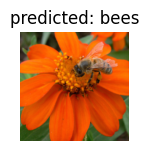

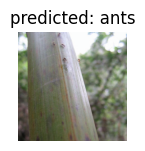

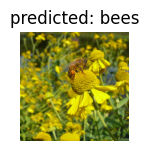

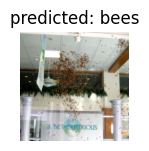

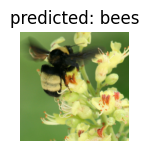

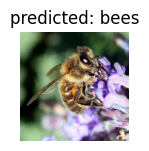

In [13]:
visualize_model(transpiled_model)

### Conclusion

We've just seen how the transpiler can be used to convert a model from PyTorch to TensorFlow and train the converted model in TensorFlow.

Head over to the [tutorials](https://unify.ai/docs/ivy/demos/) section in our documentation if you’d like to explore other demos like this. You can also run demos locally on your own machine by [signing up](https://console.unify.ai/) to get a transpiler API key for local development.

If you have any questions or suggestions for other interesting demos you'd like to see, feel free to ask on our [Discord](https://discord.gg/sXyFF8tDtm) community server, we look forward to seeing you there!